In [1]:
# logistic_regression.py

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score
)

In [5]:
# ---------------------------
# 1. Load Data
# ---------------------------
train = pd.read_csv("..\data\encoded_loan_data_train.csv")
test = pd.read_csv("..\data\encoded_loan_data_test.csv")

X_train = train.drop(columns=["Default"])
y_train = train["Default"]

X_test = test.drop(columns=["Default"])
y_test = test["Default"]

if "LoanID" in X_train.columns:
    X_train = X_train.drop(columns=["LoanID"])
    X_test = X_test.drop(columns=["LoanID"])


In [11]:
# ---------------------------
# 2. Pipeline
# ---------------------------
pipeline = Pipeline([
    ("scale", StandardScaler()),
    ("logreg", LogisticRegression(
        max_iter=1000,
        class_weight="balanced"
    ))
])


In [12]:
# ---------------------------
# 3. Hyperparameter Tuning
# ---------------------------
params = {
    "logreg__C": [0.01, 0.1, 1, 10],
    "logreg__penalty": ["l1", "l2"],
    "logreg__solver": ["liblinear"]
}

grid = GridSearchCV(
    pipeline,
    params,
    cv=5,
    scoring="f1",
    n_jobs=-1
)

grid.fit(X_train, y_train)
model = grid.best_estimator_

print("Best params:", grid.best_params_)

Best params: {'logreg__C': 0.1, 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear'}



Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.67      0.78      8818
           1       0.22      0.69      0.34      1182

    accuracy                           0.68     10000
   macro avg       0.58      0.68      0.56     10000
weighted avg       0.86      0.68      0.73     10000

ROC-AUC: 0.749228427931024
Confusion Matrix: 
 [[5930 2888]
 [ 361  821]]


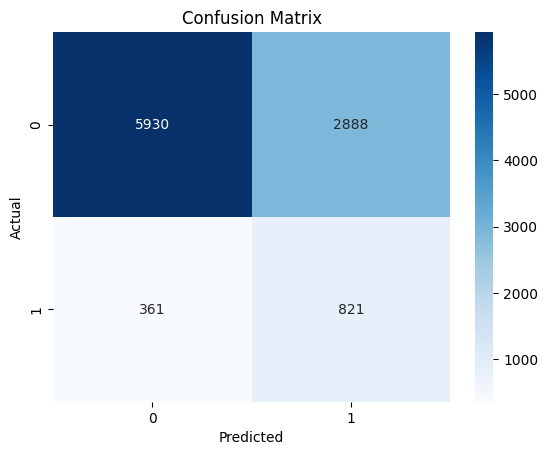

In [15]:
# ---------------------------
# 4. Evaluation
# ---------------------------
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("ROC-AUC:", roc_auc_score(y_test, y_prob))

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:", "\n", cm)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [14]:
# ---------------------------
# 5. Coefficients
# ---------------------------
coef = pd.Series(
    model.named_steps["logreg"].coef_[0],
    index=X_train.columns
).sort_values()

print("\nTop 10 Increasing Risk:")
print(coef.tail(10))

print("\nTop 10 Decreasing Risk:")
print(coef.head(10))


Top 10 Increasing Risk:
LoanPurpose_Auto             0.015702
EmploymentType_Part-time     0.016999
MaritalStatus_Single         0.017823
LoanPurpose_Business         0.031800
MaritalStatus_Divorced       0.042755
DTIRatio                     0.064125
EmploymentType_Unemployed    0.085242
NumCreditLines               0.100585
LoanAmount                   0.289755
InterestRate                 0.456586
dtype: float64

Top 10 Decreasing Risk:
Age                        -0.585562
MonthsEmployed             -0.341836
Income                     -0.314716
HasCoSigner                -0.133208
HasDependents              -0.121225
CreditScore                -0.119667
EmploymentType_Full-time   -0.104685
Education                  -0.100659
HasMortgage                -0.083862
LoanPurpose_Home           -0.064651
dtype: float64
